In [1]:

import sys
import os
import torch
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium


# insert the current absoulute path of .ipynb file into system path for moulde import from other .py files
src_path = os.path.abspath(os.path.join(os.path.dirname('/home/yl/Bike/vis_prediction.ipynb'), ".."))
sys.path.insert(0, src_path)
from src.utils.data_utils import load_hetero_data,denormalize
from src.data.dataset_generator import create_data_loaders
from src.models import h_tgnn
from src.config import get_args
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model loading and data processing

In [2]:

node_dynamicfeatures_optimized=np.load('Data/processed_data/inputsarrayforTGNN_dynamicfeatures(flowsweatherhourday).npy') # (5833, 1615, 8)
node_staticfeatures_optimized=np.load('Data/processed_data/inputsarrayforTGNN_staticfeatures(poicensus).npy') # (1, 1615, 11)
hetero_data_example = load_hetero_data('Data/processed_data/hetero_data_addcensus1.pkl')
print(hetero_data_example.metadata())
args=get_args()
train_dataset,val_dataset,test_dataset,train_dataloader, val_dataloader, test_dataloader=\
create_data_loaders(node_dynamicfeatures_optimized, hetero_data_example,args)

(['station_poi', 'census_zone', 'poi_category'], [('station', 'adjacent_to', 'station'), ('station', 'near_poi_category', 'poi_category'), ('station', 'located_in', 'census_zone')])


In [3]:
model =h_tgnn.HeteroGNN(16,32,3)
modelpath='Log/models/bestmodel/bestmodel_hetero-gru_16_32.pt'
# model = h_tgnn.GRU(16,32,3)
# modelpath='../../Log/models/bestmodel/bestmodel_GRU_16_32.pt'

state_dict = torch.load(modelpath, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)


/tmp/ipykernel_4091/4017035662.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(modelpath, map_location=device)


## Predicting flows by selectedsationFID

In [9]:
def PredictionbyStation(station_id):
    '''
    Return the prediction of one selected station
    
    '''
    predictions=[]
    trues=[]
    with torch.no_grad(): 
        image_list=[]
        for i, a in enumerate(val_dataloader):
            # select the first batch for prediction
            if i==1:
                break
            image_list.append(a)
            x_dict, target= a
            # Record the prediction starting from 0:00 to 24:00
            # print(x_dict['features']['hour_of_day'].shape)
            # print(x_dict['features']['hour_of_day'][0,0:6,0,...])
            # print(x_dict['features']['hour_of_day'][1,0:6,0,...])
            
            ## 满足station_id条件的位置掩码
            mask=x_dict['features']['station_fid'][0,0,...,0]==station_id
            mask=mask.cpu().numpy()
            
            target=target.permute(0, 2, 1)
            y_prediction = model(x_dict)
            y_true= denormalize(target, train_dataset.scaler['target']['min'],
                                            train_dataset.scaler['target']['max'])
            y_prediction = denormalize(y_prediction, train_dataset.scaler['target']['min'],
                                            train_dataset.scaler['target']['max']).cpu().numpy()
            predictions.append(y_prediction)
            trues.append(y_true)
            
    predictions_array=np.concatenate(predictions,axis=0)
    trues_array=np.concatenate(trues,axis=0)
    print(predictions_array.shape,trues_array.shape)
    predictions_array=np.transpose(predictions_array,(1,0,2))
    trues_array=np.transpose(trues_array,(1,0,2))
    predictions_array=np.reshape(predictions_array,(predictions_array.shape[0],-1))[mask].squeeze(0)
    trues_array=np.reshape(trues_array,(trues_array.shape[0],-1))[mask].squeeze(0)
    print(predictions_array.shape,trues_array.shape)
    
    return predictions_array,trues_array

In [4]:
station_id=240
predictions_array,trues_array=PredictionbyStation(station_id)

NameError: name 'PredictionbyStation' is not defined

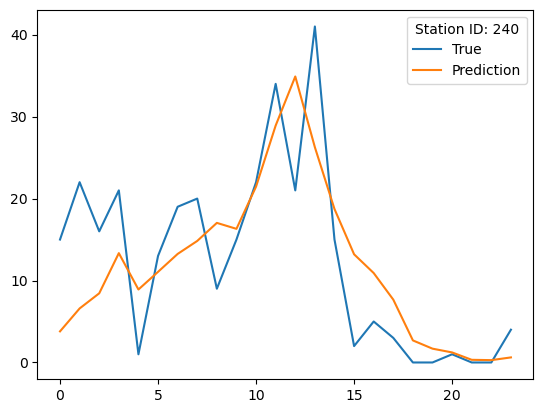

In [11]:
def vis_stationfid(i,station_id):
    plt.plot(trues_array[i:i+24],label='True')
    plt.plot(predictions_array[i:i+24],label='Prediction')
    plt.legend(title=f'Station ID: {station_id}')
   
vis_stationfid(12,station_id)

## Visualize the selected station on map
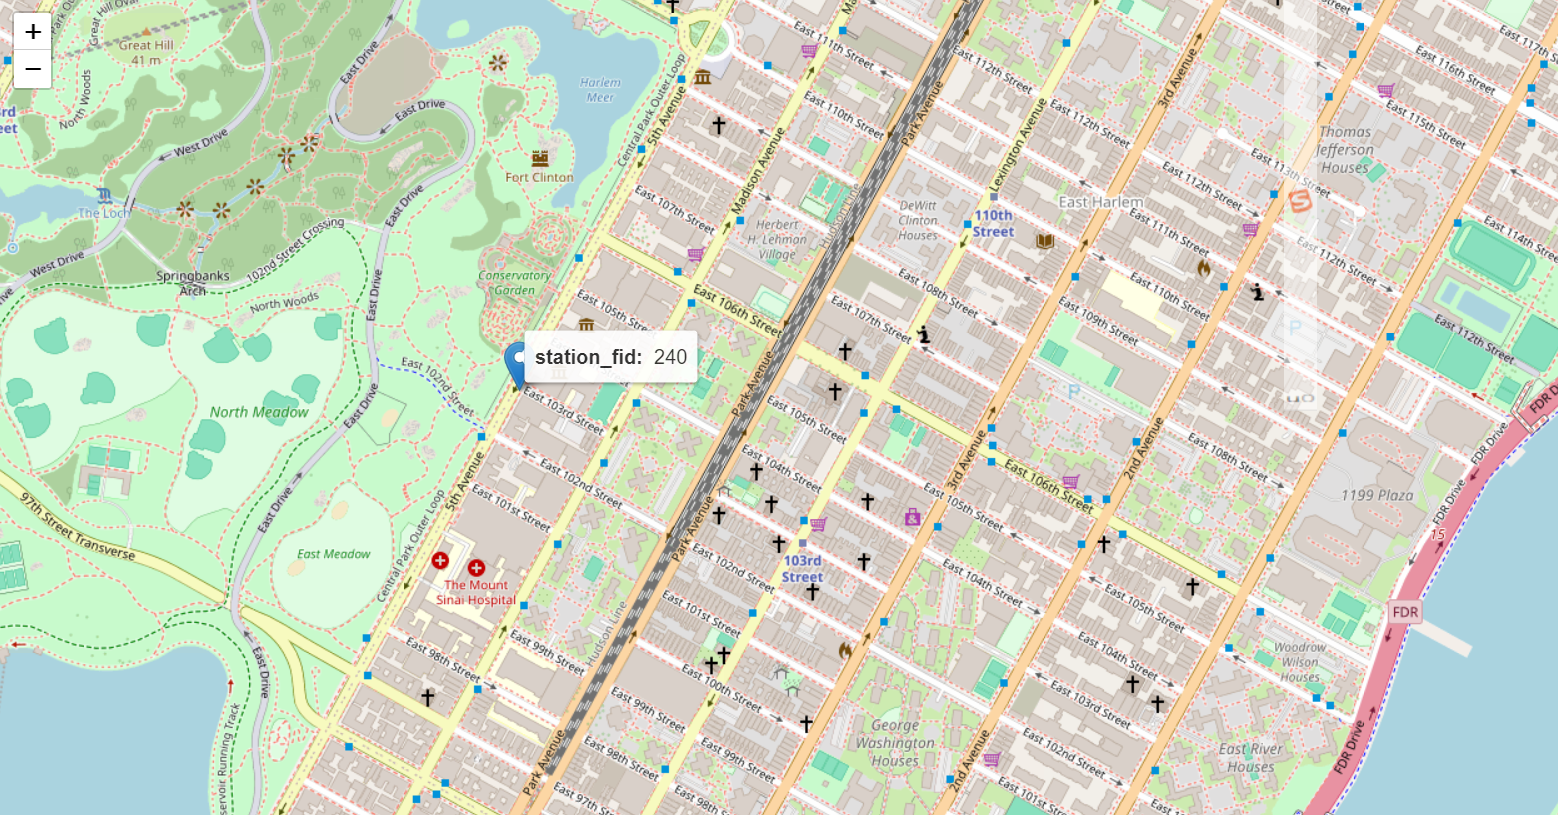

In [5]:
bike_gdf=gpd.read_parquet('/home/yl/Bike/Data/processed_data/bikegdfbeforemodel.parquet').query('day>"2022-04-01"').to_crs('EPSG:4326').drop_duplicates(subset='station_name')
query_string = f"station_fid == {station_id}"
station=bike_gdf.query(query_string)

In [13]:

tiles= "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
attr = (
'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
)

interactive_map = folium.Map(
    # tiles=tiles,
    # attr=attr,
    location=(station.geometry.y,station.geometry.x),
    zoom_start=15,
)

def style_function(feature):
    return {
        "color": "transparent",
        "fillColor": "transparent"
    }
# Click the marker, show property:station_fid
tooltip = folium.features.GeoJsonTooltip(
    fields=("station_fid",),
    aliases=("station_fid:",)
)

tooltip_layer = folium.features.GeoJson(
    bike_gdf.query(query_string),
    style_function=style_function,
    tooltip=tooltip
)
tooltip_layer.add_to(interactive_map)

interactive_map





/home/yl/miniconda3/envs/bike/lib/python3.12/site-packages/folium/utilities.py:101: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/home/yl/miniconda3/envs/bike/lib/python3.12/site-packages/folium/utilities.py:107: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/home/yl/miniconda3/envs/bike/lib/python3.12/site-packages/folium/utilities.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]
